# Strided Convolution Ablation Study
This notebook investigates the effect of using Strided Convolutions instead of Max Pooling for downsampling in the Intermediate Fusion model.
It compares:
1.  MaxPool2d: Standard max pooling layers.
2.  Strided Convolution: Convolutional layers with striding to learn downsampling.

The models are defined in `src/models.py` (`IntermediateFusionModel` vs `IntermediateFusionModelStrided`, `Embedder` vs `EmbedderStrided`).


## Setup
This is similar to `02_fusion_comparison.ipynb`. Check that for more detailed explainations.

In [ ]:
from pathlib import Path
import sys
import os
try:
    from google.colab import drive
    drive.mount('/gdrive')
    print("Mounted Google Drive")
    DATA_DIR = Path('/gdrive/MyDrive/extended_assessments/Multimodal_Learning/data')
    sys.path.append(os.path.abspath('/gdrive/MyDrive/extended_assessments/Multimodal_Learning'))
except:
    print("Running locally")
    DATA_DIR = Path('../data')
    sys.path.append(os.path.abspath('../.'))
print(f"Using {DATA_DIR} as data source")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import wandb

# Import dataset and models from src
import sys
import os
from src.datasets import CubesAndShperesDataset
from src.models import IntermediateFusionModel, IntermediateFusionModelStrided
from src.training import train_model, evaluate_model, count_parameters

# Configuration
BATCH_SIZE = 32
EPOCHS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")


set_seeds(51)

## Datasets
The dataset class used is `CubesAndShperesDataset` from `src/datasets`. A noteworthy difference to the dataset from the NVIDIA Lab is, that I normalized the LiDAR values to be between 0 and 1 and not 0 and 50.

Since the CPU compute on google collab seems quite low and building the dataset took quite some time, I added the option to export the datasets and load them again, reducing the creation compute overhead. The first cell below tries to load the precomputed dataset from `dataset_precomputed.pkl`. The second cell below builds the datasets from scratch and the third cell below exports the created datasets into the `dataset_precomputed.pkl` file.

**If the precomputed file is available, only run the first of the three following cells!**
Otherwise this will take up to three hours!

The splitting logic is aligned with the NVIDIA Lab, where we take 10 Batches of 32 Samples per class for validation. This splitting is not very sophisticated, but I wanted to maintain alignment with the original experiments, since the final evaluation uses the Lab numbers as well. 

In [ ]:
# load precomputed dataset
import pickle
with open("/gdrive/MyDrive/extended_assessments/Multimodal_Learning/notebooks/dataset_precomputed.pkl", "rb") as f:
    data = pickle.load(f)
train_indices = data["train_indices"]
val_indices = data["val_indices"]
train_dataset = data["train_dataset"]
val_dataset = data["val_dataset"]

In [ ]:
# Build Datasets
full_dataset = CubesAndShperesDataset(DATA_DIR)

# Split into Train and Validation (No Test)
# Logic from 05_Assessment.ipynb: Last VALID_BATCHES * BATCH_SIZE are validation

total_len = len(full_dataset)
n_classes = 2
samples_per_class = total_len // n_classes

VALID_BATCHES = 10
valid_samples_per_class = VALID_BATCHES * BATCH_SIZE
train_samples_per_class = samples_per_class - valid_samples_per_class

train_indices = []
val_indices = []
for i in range(n_classes):
    start_idx = i * samples_per_class
    train_indices.extend(range(start_idx, start_idx + train_samples_per_class))
    val_indices.extend(range(start_idx + train_samples_per_class, start_idx + samples_per_class))

from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [ ]:
import pickle
with open("dataset_precomputed.pkl", "wb") as f:
    pickle.dump({
        "train_indices": train_indices,
        "val_indices": val_indices,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset
    }, f)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total samples: {total_len}")
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

## Model Definitions

We use the `IntermediateFusionModel` and `IntermediateFusionModelStrided` from `src/models.py`.

The difference is, that while th original `IntermediateFusionModel` uses an untrainable `MaxPool2d` layer, we now have trainable `Conv2d` layers. This increases the prameter count and thus the compute and time required for training, but it allows for more sophisticated downsampling.

## Experiments

We iterate over a set of Hyperparameters again. The selection of strategies is based on the resutls fo the previous task.

In [ ]:
results = {}

# Hyperparameters to test
learning_rates = [1e-3, 1e-4, 1e-5]
use_schedulers = [True, False]

# Define models to test
# Format: (Name, ID, ModelClass, InitArgs)
strategies = [
    ("MaxPool2d", "maxpool", IntermediateFusionModel, {'fusion_type': 'concat'}),
    ("Strided Conv", "strided-conv", IntermediateFusionModelStrided, {'fusion_type': 'concat'}),
]
best_val_acc = 0.0
best_model_info = None
for name, strategy_id, model_cls, model_kwargs in strategies:
    for lr in learning_rates:
        for use_sched in use_schedulers:
            sched_str = "cosine" if use_sched else "constant"
            run_name = f"{strategy_id}_lr{lr}_{sched_str}"
            
            print(f"\n=== Training {name} | LR: {lr} | Scheduler: {sched_str} ===")
            
            wandb.init(project="clip-extended-assessment", name=run_name, entity="jan-kubeler-hpi", config={
                "downsampling": strategy_id,
                "batch_size": BATCH_SIZE,
                "learning_rate": lr,
                "scheduler": sched_str,
                "epochs": EPOCHS
            })
            
            # Initialize model
            model = model_cls(**model_kwargs).to(DEVICE)
            model_params = count_parameters(model)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            scheduler = None
            if use_sched:
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
            
            # Train
            train_loss, val_loss, val_acc, train_time = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS, scheduler=scheduler, use_wandb=True)
            
            # Evaluate on Validation Set (since we don't have a separate test set)
            final_acc, _, _, _ = evaluate_model(model, val_loader)
            
            results[run_name] = {
                'Validation Loss': val_loss[-1],
                'Parameters': model_params,
                'Training Time (s)': train_time,
                'Final Accuracy': final_acc
            }
            
            print(f"Final Val Metrics: Acc={final_acc:.4f}")
            
            if final_acc > best_val_acc:
                best_val_acc = final_acc
                best_model_info = {
                    "name": name,
                    "strategy_id": strategy_id,
                    "model_cls": model_cls,
                    "model_kwargs": model_kwargs,
                    "learning_rate": lr,
                    "scheduler": sched_str,
                    "accuracy": final_acc,
                }
                torch.save(model.state_dict(), f"/gdrive/MyDrive/extended_assessments/Multimodal_Learning/checkpoints/best_stride_abl_model.pth")
                with open("/gdrive/MyDrive/extended_assessments/Multimodal_Learning/checkpoints/best_stride_abl_model_info.txt", "wb") as f:
                    f.write(str(best_model_info).encode())

            wandb.finish()


=== Training MaxPool2d | LR: 0.001 | Scheduler: cosine ===


wandb: Currently logged in as: jan-kubeler (gorillawatch) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[MaxPool2d] Epoch 1/8, LR: 0.000962, Train Loss: 0.2151, Val Loss: 0.0977, Val Acc: 0.9386
[MaxPool2d] Epoch 2/8, LR: 0.000854, Train Loss: 0.0451, Val Loss: 0.0208, Val Acc: 0.9944
[MaxPool2d] Epoch 2/8, LR: 0.000854, Train Loss: 0.0451, Val Loss: 0.0208, Val Acc: 0.9944
[MaxPool2d] Epoch 3/8, LR: 0.000691, Train Loss: 0.0275, Val Loss: 0.0056, Val Acc: 0.9988
[MaxPool2d] Epoch 3/8, LR: 0.000691, Train Loss: 0.0275, Val Loss: 0.0056, Val Acc: 0.9988
[MaxPool2d] Epoch 4/8, LR: 0.000500, Train Loss: 0.0020, Val Loss: 0.0015, Val Acc: 0.9988
[MaxPool2d] Epoch 4/8, LR: 0.000500, Train Loss: 0.0020, Val Loss: 0.0015, Val Acc: 0.9988
[MaxPool2d] Epoch 5/8, LR: 0.000309, Train Loss: 0.0001, Val Loss: 0.0017, Val Acc: 0.9994
[MaxPool2d] Epoch 5/8, LR: 0.000309, Train Loss: 0.0001, Val Loss: 0.0017, Val Acc: 0.9994
[MaxPool2d] Epoch 6/8, LR: 0.000146, Train Loss: 0.0000, Val Loss: 0.0018, Val Acc: 0.9994
[MaxPool2d] Epoch 6/8, LR: 0.000146, Train Loss: 0.0000, Val Loss: 0.0018, Val Acc: 0.9994

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▆▅▃▂▁▁
train_loss,█▂▂▁▁▁▁▁
val_acc,▁▇██████
val_loss,█▂▁▁▁▁▁▁
epoch,8
learning_rate,0
train_loss,3e-05
val_acc,0.99938
val_loss,0.00189



=== Training MaxPool2d | LR: 0.001 | Scheduler: constant ===


[MaxPool2d] Epoch 1/8, LR: 0.001000, Train Loss: 0.2308, Val Loss: 0.2149, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.001000, Train Loss: 0.1202, Val Loss: 0.0418, Val Acc: 0.9895
[MaxPool2d] Epoch 2/8, LR: 0.001000, Train Loss: 0.1202, Val Loss: 0.0418, Val Acc: 0.9895
[MaxPool2d] Epoch 3/8, LR: 0.001000, Train Loss: 0.0387, Val Loss: 0.0636, Val Acc: 0.9739
[MaxPool2d] Epoch 3/8, LR: 0.001000, Train Loss: 0.0387, Val Loss: 0.0636, Val Acc: 0.9739
[MaxPool2d] Epoch 4/8, LR: 0.001000, Train Loss: 0.0250, Val Loss: 0.0264, Val Acc: 0.9944
[MaxPool2d] Epoch 4/8, LR: 0.001000, Train Loss: 0.0250, Val Loss: 0.0264, Val Acc: 0.9944
[MaxPool2d] Epoch 5/8, LR: 0.001000, Train Loss: 0.0156, Val Loss: 0.0313, Val Acc: 0.9901
[MaxPool2d] Epoch 5/8, LR: 0.001000, Train Loss: 0.0156, Val Loss: 0.0313, Val Acc: 0.9901
[MaxPool2d] Epoch 6/8, LR: 0.001000, Train Loss: 0.0099, Val Loss: 0.0273, Val Acc: 0.9907
[MaxPool2d] Epoch 6/8, LR: 0.001000, Train Loss: 0.0099, Val Loss: 0.0273, Val Acc: 0.9907

epoch,▁▂▃▄▅▆▇█
learning_rate,▁▁▁▁▁▁▁▁
train_loss,█▅▂▂▁▁▁▁
val_acc,▁▇▆█▇▇██
val_loss,█▂▃▂▂▂▁▁
epoch,8
learning_rate,0.001
train_loss,0.00894
val_acc,0.9969
val_loss,0.0132



=== Training MaxPool2d | LR: 0.0001 | Scheduler: cosine ===


[MaxPool2d] Epoch 1/8, LR: 0.000096, Train Loss: 0.2440, Val Loss: 0.2161, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000085, Train Loss: 0.1974, Val Loss: 0.1856, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000085, Train Loss: 0.1974, Val Loss: 0.1856, Val Acc: 0.9268
[MaxPool2d] Epoch 3/8, LR: 0.000069, Train Loss: 0.1571, Val Loss: 0.1397, Val Acc: 0.9287
[MaxPool2d] Epoch 3/8, LR: 0.000069, Train Loss: 0.1571, Val Loss: 0.1397, Val Acc: 0.9287
[MaxPool2d] Epoch 4/8, LR: 0.000050, Train Loss: 0.0905, Val Loss: 0.0581, Val Acc: 0.9876
[MaxPool2d] Epoch 4/8, LR: 0.000050, Train Loss: 0.0905, Val Loss: 0.0581, Val Acc: 0.9876
[MaxPool2d] Epoch 5/8, LR: 0.000031, Train Loss: 0.0345, Val Loss: 0.0332, Val Acc: 0.9938
[MaxPool2d] Epoch 5/8, LR: 0.000031, Train Loss: 0.0345, Val Loss: 0.0332, Val Acc: 0.9938
[MaxPool2d] Epoch 6/8, LR: 0.000015, Train Loss: 0.0139, Val Loss: 0.0125, Val Acc: 0.9969
[MaxPool2d] Epoch 6/8, LR: 0.000015, Train Loss: 0.0139, Val Loss: 0.0125, Val Acc: 0.9969

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▆▅▃▂▁▁
train_loss,█▇▅▃▂▁▁▁
val_acc,▁▁▁▇████
val_loss,█▇▅▃▂▁▁▁
epoch,8
learning_rate,0
train_loss,0.0053
val_acc,0.99752
val_loss,0.00869



=== Training MaxPool2d | LR: 0.0001 | Scheduler: constant ===


[MaxPool2d] Epoch 1/8, LR: 0.000100, Train Loss: 0.2508, Val Loss: 0.2495, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000100, Train Loss: 0.2058, Val Loss: 0.1949, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000100, Train Loss: 0.2058, Val Loss: 0.1949, Val Acc: 0.9268
[MaxPool2d] Epoch 3/8, LR: 0.000100, Train Loss: 0.1433, Val Loss: 0.1105, Val Acc: 0.9708
[MaxPool2d] Epoch 3/8, LR: 0.000100, Train Loss: 0.1433, Val Loss: 0.1105, Val Acc: 0.9708
[MaxPool2d] Epoch 4/8, LR: 0.000100, Train Loss: 0.0724, Val Loss: 0.0671, Val Acc: 0.9770
[MaxPool2d] Epoch 4/8, LR: 0.000100, Train Loss: 0.0724, Val Loss: 0.0671, Val Acc: 0.9770
[MaxPool2d] Epoch 5/8, LR: 0.000100, Train Loss: 0.0266, Val Loss: 0.0301, Val Acc: 0.9919
[MaxPool2d] Epoch 5/8, LR: 0.000100, Train Loss: 0.0266, Val Loss: 0.0301, Val Acc: 0.9919
[MaxPool2d] Epoch 6/8, LR: 0.000100, Train Loss: 0.0073, Val Loss: 0.0107, Val Acc: 0.9950
[MaxPool2d] Epoch 6/8, LR: 0.000100, Train Loss: 0.0073, Val Loss: 0.0107, Val Acc: 0.9950

epoch,▁▂▃▄▅▆▇█
learning_rate,▁▁▁▁▁▁▁▁
train_loss,█▇▅▃▂▁▁▁
val_acc,▁▁▅▆▇███
val_loss,█▆▄▃▂▁▁▁
epoch,8
learning_rate,0.0001
train_loss,0.0006
val_acc,0.99814
val_loss,0.00388



=== Training MaxPool2d | LR: 1e-05 | Scheduler: cosine ===


[MaxPool2d] Epoch 1/8, LR: 0.000010, Train Loss: 0.2656, Val Loss: 0.2599, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000009, Train Loss: 0.2532, Val Loss: 0.2566, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000009, Train Loss: 0.2532, Val Loss: 0.2566, Val Acc: 0.9268
[MaxPool2d] Epoch 3/8, LR: 0.000007, Train Loss: 0.2449, Val Loss: 0.2517, Val Acc: 0.9268
[MaxPool2d] Epoch 3/8, LR: 0.000007, Train Loss: 0.2449, Val Loss: 0.2517, Val Acc: 0.9268
[MaxPool2d] Epoch 4/8, LR: 0.000005, Train Loss: 0.2378, Val Loss: 0.2452, Val Acc: 0.9268
[MaxPool2d] Epoch 4/8, LR: 0.000005, Train Loss: 0.2378, Val Loss: 0.2452, Val Acc: 0.9268
[MaxPool2d] Epoch 5/8, LR: 0.000003, Train Loss: 0.2328, Val Loss: 0.2423, Val Acc: 0.9268
[MaxPool2d] Epoch 5/8, LR: 0.000003, Train Loss: 0.2328, Val Loss: 0.2423, Val Acc: 0.9268
[MaxPool2d] Epoch 6/8, LR: 0.000001, Train Loss: 0.2258, Val Loss: 0.2385, Val Acc: 0.9268
[MaxPool2d] Epoch 6/8, LR: 0.000001, Train Loss: 0.2258, Val Loss: 0.2385, Val Acc: 0.9268

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▆▅▃▂▁▁
train_loss,█▆▅▃▃▂▁▁
val_acc,▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▃▂▁▁
epoch,8
learning_rate,0
train_loss,0.2224
val_acc,0.9268
val_loss,0.23291



=== Training MaxPool2d | LR: 1e-05 | Scheduler: constant ===


[MaxPool2d] Epoch 1/8, LR: 0.000010, Train Loss: 0.2590, Val Loss: 0.2601, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000010, Train Loss: 0.2533, Val Loss: 0.2597, Val Acc: 0.9268
[MaxPool2d] Epoch 2/8, LR: 0.000010, Train Loss: 0.2533, Val Loss: 0.2597, Val Acc: 0.9268
[MaxPool2d] Epoch 3/8, LR: 0.000010, Train Loss: 0.2484, Val Loss: 0.2528, Val Acc: 0.9268
[MaxPool2d] Epoch 3/8, LR: 0.000010, Train Loss: 0.2484, Val Loss: 0.2528, Val Acc: 0.9268
[MaxPool2d] Epoch 4/8, LR: 0.000010, Train Loss: 0.2386, Val Loss: 0.2472, Val Acc: 0.9268
[MaxPool2d] Epoch 4/8, LR: 0.000010, Train Loss: 0.2386, Val Loss: 0.2472, Val Acc: 0.9268
[MaxPool2d] Epoch 5/8, LR: 0.000010, Train Loss: 0.2318, Val Loss: 0.2362, Val Acc: 0.9268
[MaxPool2d] Epoch 5/8, LR: 0.000010, Train Loss: 0.2318, Val Loss: 0.2362, Val Acc: 0.9268
[MaxPool2d] Epoch 6/8, LR: 0.000010, Train Loss: 0.2205, Val Loss: 0.2270, Val Acc: 0.9268
[MaxPool2d] Epoch 6/8, LR: 0.000010, Train Loss: 0.2205, Val Loss: 0.2270, Val Acc: 0.9268

epoch,▁▂▃▄▅▆▇█
learning_rate,▁▁▁▁▁▁▁▁
train_loss,█▇▇▅▅▃▂▁
val_acc,▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▄▁▁
epoch,8
learning_rate,1e-05
train_loss,0.20268
val_acc,0.9268
val_loss,0.20845



=== Training Strided Conv | LR: 0.001 | Scheduler: cosine ===


[Strided Conv] Epoch 1/8, LR: 0.000962, Train Loss: 0.2266, Val Loss: 0.1973, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000854, Train Loss: 0.1728, Val Loss: 0.1898, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000854, Train Loss: 0.1728, Val Loss: 0.1898, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000691, Train Loss: 0.1478, Val Loss: 0.1344, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000691, Train Loss: 0.1478, Val Loss: 0.1344, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000500, Train Loss: 0.1190, Val Loss: 0.0819, Val Acc: 0.9702
[Strided Conv] Epoch 4/8, LR: 0.000500, Train Loss: 0.1190, Val Loss: 0.0819, Val Acc: 0.9702
[Strided Conv] Epoch 5/8, LR: 0.000309, Train Loss: 0.0583, Val Loss: 0.0226, Val Acc: 0.9913
[Strided Conv] Epoch 5/8, LR: 0.000309, Train Loss: 0.0583, Val Loss: 0.0226, Val Acc: 0.9913
[Strided Conv] Epoch 6/8, LR: 0.000146, Train Loss: 0.0205, Val Loss: 0.0086, Val Acc: 0.9981
[Strided Conv] Epoch 6/8, LR: 0.000146, Train Loss: 0.0205, 

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▆▅▃▂▁▁
train_loss,█▆▆▅▃▂▁▁
val_acc,▁▁▁▅▇███
val_loss,██▆▄▂▁▁▁
epoch,8
learning_rate,0
train_loss,0.00227
val_acc,0.9969
val_loss,0.01094



=== Training Strided Conv | LR: 0.001 | Scheduler: constant ===


[Strided Conv] Epoch 1/8, LR: 0.001000, Train Loss: 0.2298, Val Loss: 0.2135, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.001000, Train Loss: 0.1883, Val Loss: 0.1787, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.001000, Train Loss: 0.1883, Val Loss: 0.1787, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.001000, Train Loss: 0.1387, Val Loss: 0.1091, Val Acc: 0.9330
[Strided Conv] Epoch 3/8, LR: 0.001000, Train Loss: 0.1387, Val Loss: 0.1091, Val Acc: 0.9330
[Strided Conv] Epoch 4/8, LR: 0.001000, Train Loss: 0.1154, Val Loss: 0.1091, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.001000, Train Loss: 0.1154, Val Loss: 0.1091, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.001000, Train Loss: 0.0921, Val Loss: 0.1100, Val Acc: 0.9448
[Strided Conv] Epoch 5/8, LR: 0.001000, Train Loss: 0.0921, Val Loss: 0.1100, Val Acc: 0.9448
[Strided Conv] Epoch 6/8, LR: 0.001000, Train Loss: 0.0813, Val Loss: 0.0583, Val Acc: 0.9733
[Strided Conv] Epoch 6/8, LR: 0.001000, Train Loss: 0.0813, 

epoch,▁▂▃▄▅▆▇█
learning_rate,▁▁▁▁▁▁▁▁
train_loss,▂▂▂▁▁▁█▁
val_acc,▁▁▂▁▄███
val_loss,█▆▃▃▃▁▁▁
epoch,8
learning_rate,0.001
train_loss,0.06129
val_acc,0.97581
val_loss,0.06754



=== Training Strided Conv | LR: 0.0001 | Scheduler: cosine ===


[Strided Conv] Epoch 1/8, LR: 0.000096, Train Loss: 0.2467, Val Loss: 0.2114, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000085, Train Loss: 0.2001, Val Loss: 0.2004, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000085, Train Loss: 0.2001, Val Loss: 0.2004, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000069, Train Loss: 0.1904, Val Loss: 0.2384, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000069, Train Loss: 0.1904, Val Loss: 0.2384, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000050, Train Loss: 0.1744, Val Loss: 0.1595, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000050, Train Loss: 0.1744, Val Loss: 0.1595, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000031, Train Loss: 0.1410, Val Loss: 0.1406, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000031, Train Loss: 0.1410, Val Loss: 0.1406, Val Acc: 0.9268
[Strided Conv] Epoch 6/8, LR: 0.000015, Train Loss: 0.1188, Val Loss: 0.1127, Val Acc: 0.9380
[Strided Conv] Epoch 6/8, LR: 0.000015, Train Loss: 0.1188, 

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▆▅▃▂▁▁
train_loss,█▆▅▅▃▂▂▁
val_acc,▁▁▁▁▁▄▇█
val_loss,▇▆█▄▃▂▁▁
epoch,8
learning_rate,0
train_loss,0.09022
val_acc,0.95347
val_loss,0.10072



=== Training Strided Conv | LR: 0.0001 | Scheduler: constant ===


[Strided Conv] Epoch 1/8, LR: 0.000100, Train Loss: 0.2457, Val Loss: 0.2161, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000100, Train Loss: 0.1982, Val Loss: 0.1918, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000100, Train Loss: 0.1982, Val Loss: 0.1918, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000100, Train Loss: 0.1822, Val Loss: 0.1771, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000100, Train Loss: 0.1822, Val Loss: 0.1771, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000100, Train Loss: 0.1579, Val Loss: 0.1462, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000100, Train Loss: 0.1579, Val Loss: 0.1462, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000100, Train Loss: 0.1156, Val Loss: 0.1050, Val Acc: 0.9460
[Strided Conv] Epoch 5/8, LR: 0.000100, Train Loss: 0.1156, Val Loss: 0.1050, Val Acc: 0.9460
[Strided Conv] Epoch 6/8, LR: 0.000100, Train Loss: 0.1013, Val Loss: 0.0913, Val Acc: 0.9516
[Strided Conv] Epoch 6/8, LR: 0.000100, Train Loss: 0.1013, 

epoch,▁▂▃▄▅▆▇█
learning_rate,▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▃▃▂▁
val_acc,▁▁▁▁▄▅▅█
val_loss,█▇▆▅▃▃▃▁
epoch,8
learning_rate,0.0001
train_loss,0.05419
val_acc,0.97581
val_loss,0.05667



=== Training Strided Conv | LR: 1e-05 | Scheduler: cosine ===


[Strided Conv] Epoch 1/8, LR: 0.000010, Train Loss: 0.2815, Val Loss: 0.2625, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000009, Train Loss: 0.2531, Val Loss: 0.2593, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000009, Train Loss: 0.2531, Val Loss: 0.2593, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000007, Train Loss: 0.2421, Val Loss: 0.2323, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000007, Train Loss: 0.2421, Val Loss: 0.2323, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000005, Train Loss: 0.2165, Val Loss: 0.2169, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000005, Train Loss: 0.2165, Val Loss: 0.2169, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000003, Train Loss: 0.2105, Val Loss: 0.2125, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000003, Train Loss: 0.2105, Val Loss: 0.2125, Val Acc: 0.9268
[Strided Conv] Epoch 6/8, LR: 0.000001, Train Loss: 0.2080, Val Loss: 0.2101, Val Acc: 0.9268
[Strided Conv] Epoch 6/8, LR: 0.000001, Train Loss: 0.2080, 

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▆▅▃▂▁▁
train_loss,█▅▄▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁
val_loss,██▄▂▁▁▁▁
epoch,8
learning_rate,0
train_loss,0.20362
val_acc,0.9268
val_loss,0.20893



=== Training Strided Conv | LR: 1e-05 | Scheduler: constant ===


[Strided Conv] Epoch 1/8, LR: 0.000010, Train Loss: 0.2750, Val Loss: 0.2691, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000010, Train Loss: 0.2542, Val Loss: 0.2620, Val Acc: 0.9268
[Strided Conv] Epoch 2/8, LR: 0.000010, Train Loss: 0.2542, Val Loss: 0.2620, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000010, Train Loss: 0.2547, Val Loss: 0.2614, Val Acc: 0.9268
[Strided Conv] Epoch 3/8, LR: 0.000010, Train Loss: 0.2547, Val Loss: 0.2614, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000010, Train Loss: 0.2463, Val Loss: 0.2329, Val Acc: 0.9268
[Strided Conv] Epoch 4/8, LR: 0.000010, Train Loss: 0.2463, Val Loss: 0.2329, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000010, Train Loss: 0.2149, Val Loss: 0.2158, Val Acc: 0.9268
[Strided Conv] Epoch 5/8, LR: 0.000010, Train Loss: 0.2149, Val Loss: 0.2158, Val Acc: 0.9268
[Strided Conv] Epoch 6/8, LR: 0.000010, Train Loss: 0.2090, Val Loss: 0.2103, Val Acc: 0.9268
[Strided Conv] Epoch 6/8, LR: 0.000010, Train Loss: 0.2090, 

epoch,▁▂▃▄▅▆▇█
learning_rate,▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▃▂▁▁
val_acc,▁▁▁▁▁▁▁▁
val_loss,█▇▇▄▂▂▁▁
epoch,8
learning_rate,1e-05
train_loss,0.19848
val_acc,0.9268
val_loss,0.20475


## 5. Comparison and Analysis

For in depth analysis, check out W&B. Here we plot the final accuracies and Training times of the different hyperparameter combinations.

                                Validation Loss  Parameters  \
maxpool_lr0.001_cosine                 0.001892  13015952.0   
maxpool_lr0.001_constant               0.013195  13015952.0   
maxpool_lr0.0001_cosine                0.008687  13015952.0   
maxpool_lr0.0001_constant              0.003878  13015952.0   
maxpool_lr1e-05_cosine                 0.232912  13015952.0   
maxpool_lr1e-05_constant               0.208453  13015952.0   
strided-conv_lr0.001_cosine            0.010942  13252552.0   
strided-conv_lr0.001_constant          0.067544  13252552.0   
strided-conv_lr0.0001_cosine           0.100721  13252552.0   
strided-conv_lr0.0001_constant         0.056673  13252552.0   
strided-conv_lr1e-05_cosine            0.208927  13252552.0   
strided-conv_lr1e-05_constant          0.204748  13252552.0   

                                Training Time (s)  Final Accuracy  
maxpool_lr0.001_cosine                 439.882924        0.999380  
maxpool_lr0.001_constant               407.0

NameError: name 'pool_val_loss' is not defined

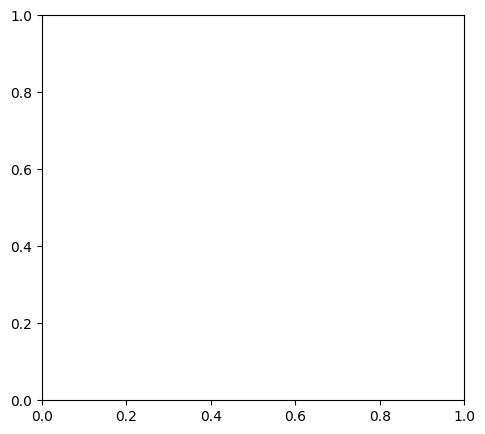

In [ ]:
# Create Comparison Table
df_results = pd.DataFrame(results).T
print(df_results)

# Bar plot of Final Accuracy
plt.figure(figsize=(12, 6))
df_results['Final Accuracy'].plot(kind='bar')
plt.title('Final Validation Accuracy by Downsampling Strategy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar plot of Training Time
plt.figure(figsize=(12, 6))
df_results['Training Time (s)'].plot(kind='bar', color='orange')
plt.title('Training Time by Downsampling Strategy')
plt.ylabel('Time (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis

#### Theoretical Thoughts
The **MaxPool** approach does not require any paramaters or complex algorithmics for computation. It simply takes the max. This makes is more lightweight in training and inference. However, since it always just takes the max, it is not very sophisticated and might miss important features.

The **StridedConv** approach replaces the ''stupid'' max pooling with learnable parameters which can lead to better feature extraction. However, this comes at the cost of having more parameters, making the model larger and more expensive to run and train. If that is worth the cost depends on the actual performance difference. 

#### Practical Results

| Metric         | MaxPool | Strided Conv | Difference |
|----------------|---------|--------------|-----------------------|
| Val Loss       |         |              |                       |
| Parameters     |         |              |                       |
| Training Time  |         |              |                       |
| Final Accuracy |         |              |                       |

**Performance:**
*   (Analyze which model achieved lower loss and higher accuracy)
*   (Analyze if the extra parameters led to overfitting or better generalization)

**Training Time:**
*   (Compare training times. Strided convs might be computationally heavier due to more multiplications, but sometimes optimized implementations are comparable)

**Conclusion:**
(Summarize findings)